# ===================================================

# Import required libraries

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
#import xgboost as XGBRegressor
#import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel, RFE, RFECV, mutual_info_regression
from sklearn.inspection import permutation_importance
#import optuna
import warnings
import pickle
import joblib
from datetime import datetime, timedelta
import os
import matplotlib.dates as mdates
from scipy import stats

# ====================================================================================
# 1. Data Loading and Initial Exploration
# ====================================================================================

Dataset loaded successfully.
Shape of dataset: (16857, 29)

Data Types:
 timestamp                        object
equipment_energy_consumption     object
lighting_energy                  object
zone1_temperature                object
zone1_humidity                   object
zone2_temperature                object
zone2_humidity                  float64
zone3_temperature               float64
zone3_humidity                  float64
zone4_temperature               float64
zone4_humidity                  float64
zone5_temperature               float64
zone5_humidity                  float64
zone6_temperature               float64
zone6_humidity                  float64
zone7_temperature               float64
zone7_humidity                  float64
zone8_temperature               float64
zone8_humidity                  float64
zone9_temperature               float64
zone9_humidity                  float64
outdoor_temperature             float64
atmospheric_pressure            float64
outdoor

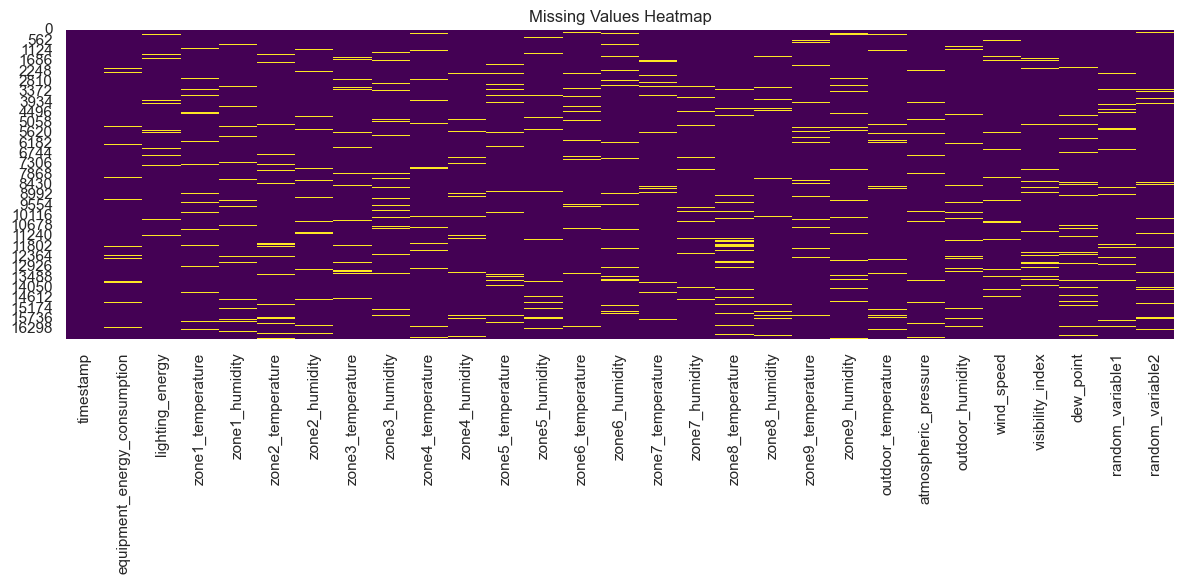

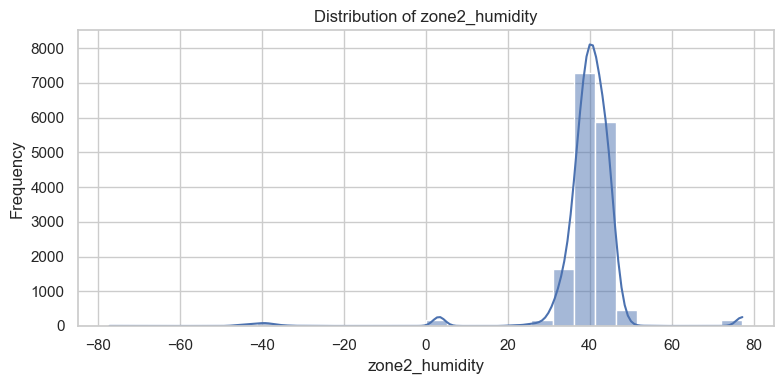

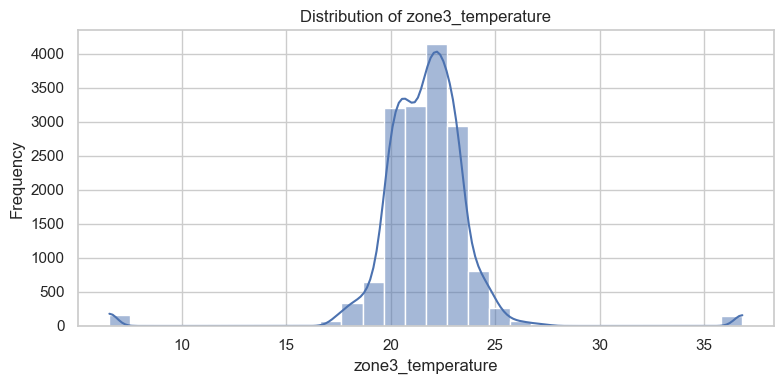

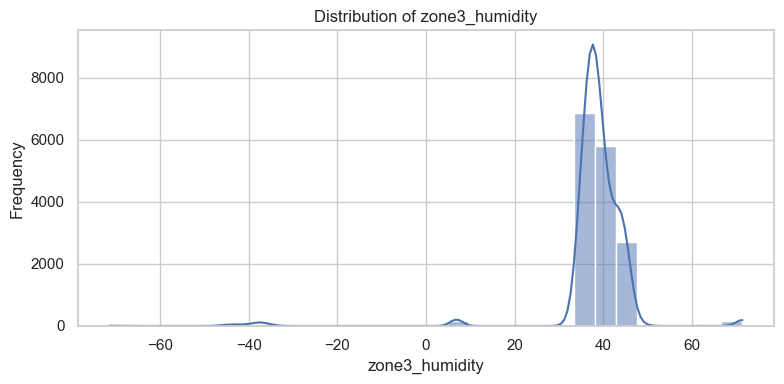

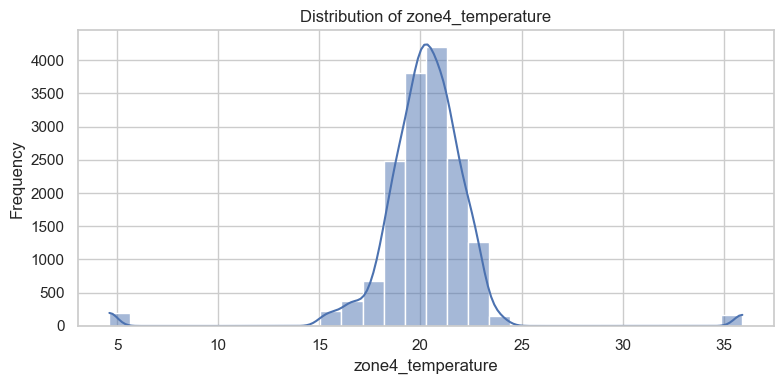

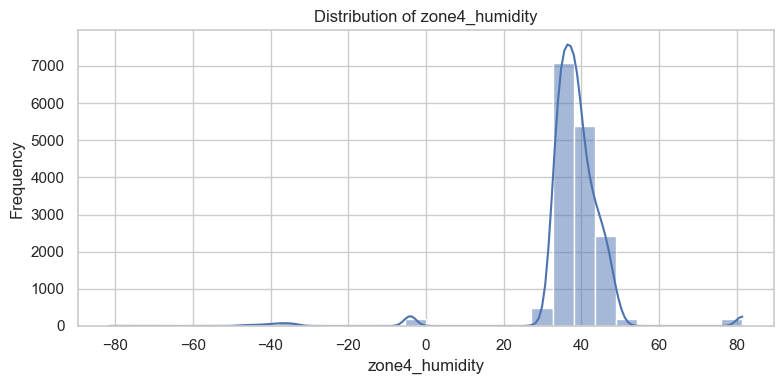

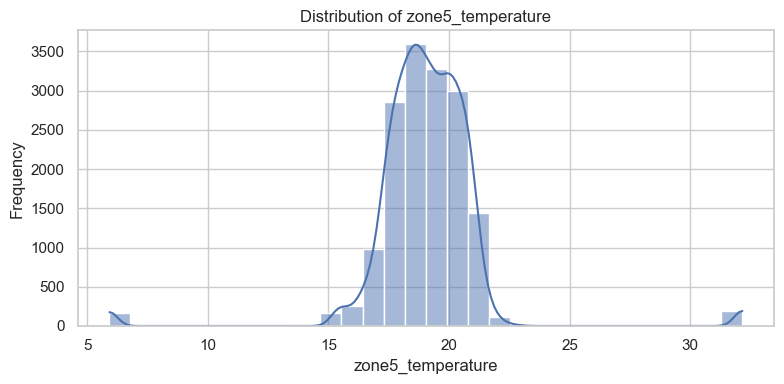

C:\Users\aliru\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


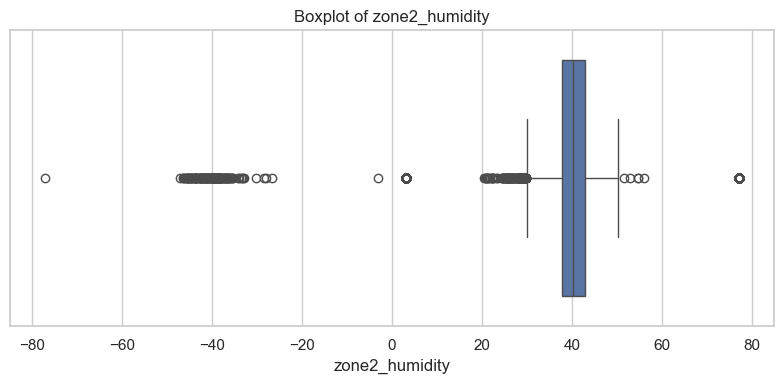

C:\Users\aliru\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


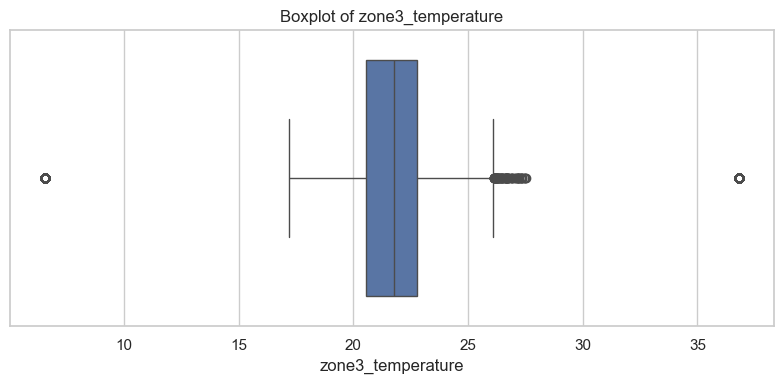

C:\Users\aliru\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


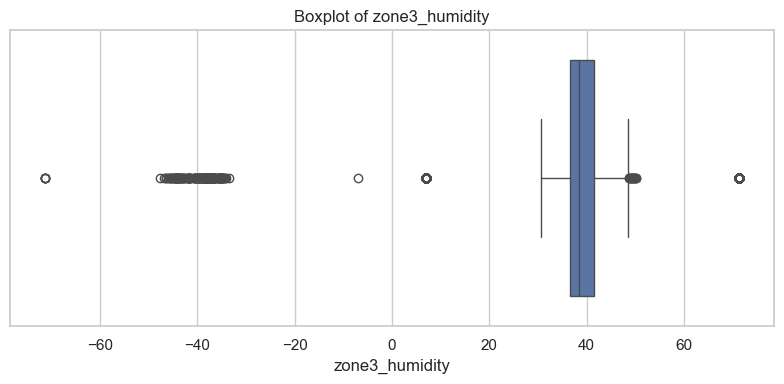

C:\Users\aliru\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


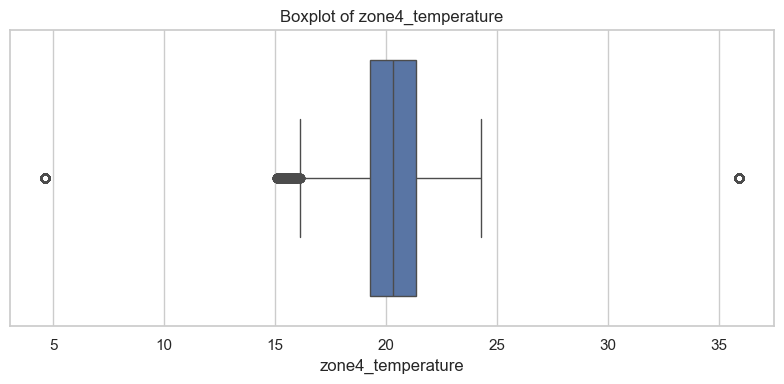

C:\Users\aliru\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


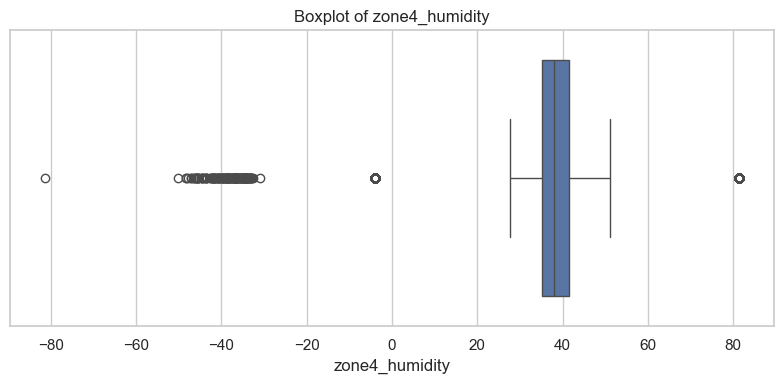

C:\Users\aliru\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


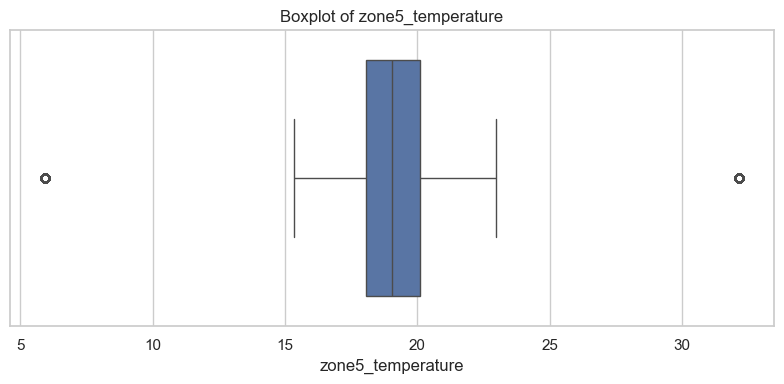

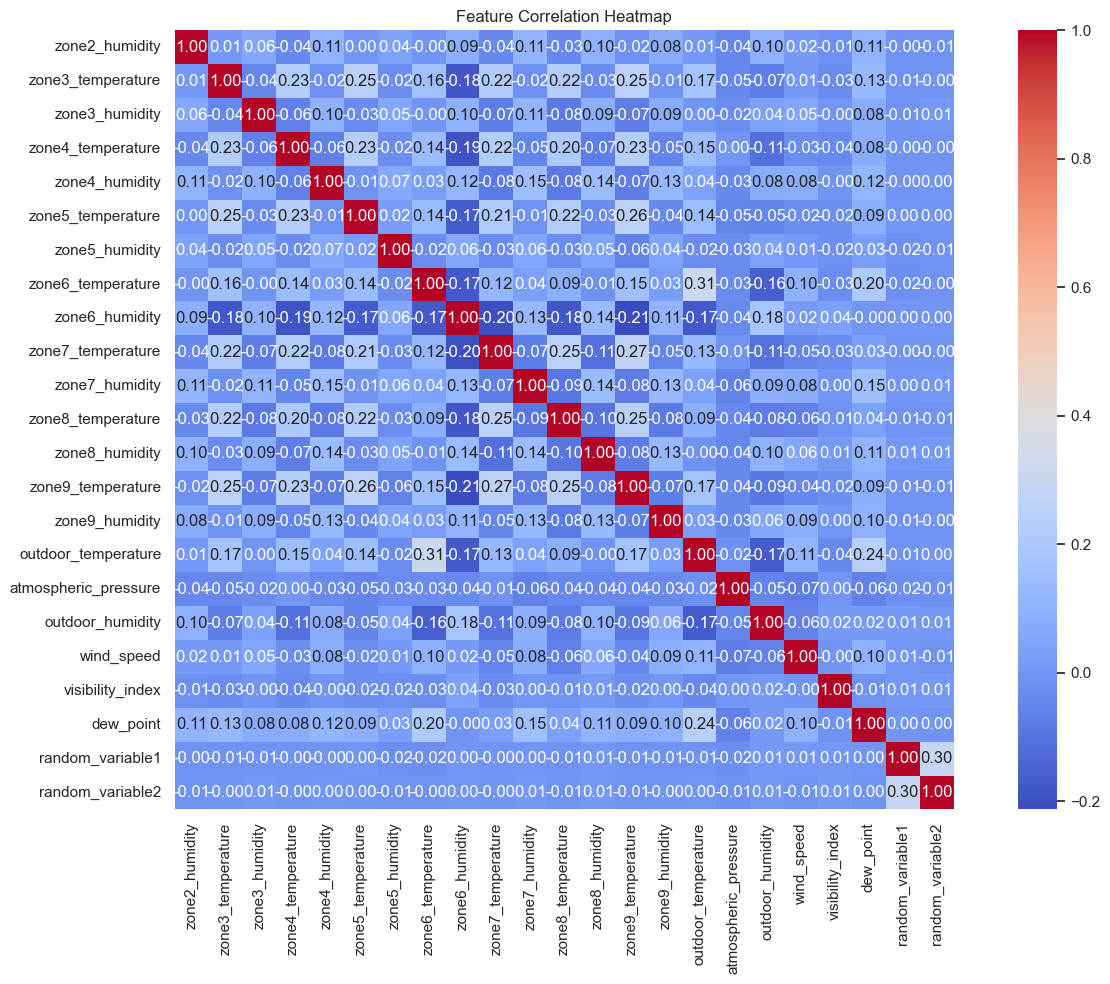

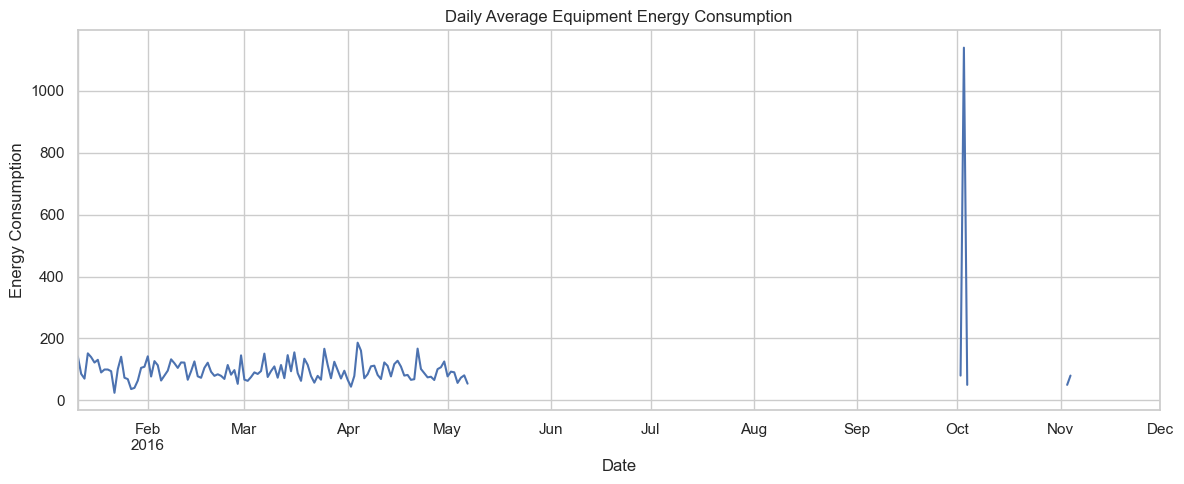

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for seaborn
sns.set(style="whitegrid")

# Load dataset
try:
    df = pd.read_csv('data/data.csv')
    print("Dataset loaded successfully.")
except Exception as e:
    print("Failed to load dataset:", e)
    exit()

# 1. Basic Info
print("Shape of dataset:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

# 2. Descriptive Statistics
print("\nSummary Statistics:\n", df.describe(include='all'))

# 3. Sample Records
print("\nSample Rows:\n", df.head())

# 4. Missing Values Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

# 5. Distribution Plots for Key Numerical Features
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numerical_cols[:6]:  # Limit to first 6 for brevity
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# 6. Boxplots for Outlier Detection
for col in numerical_cols[:6]:  # Limit to first 6
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col].dropna())
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

# 7. Correlation Heatmap
numeric_df = df[numerical_cols].copy()
numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(14, 10))
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# 8. Time Series Pattern (if 'timestamp' exists)
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df.dropna(subset=['timestamp'], inplace=True)
    df.set_index('timestamp', inplace=True)

    if 'equipment_energy_consumption' in df.columns:
        # Ensure numeric format
        df['equipment_energy_consumption'] = pd.to_numeric(
            df['equipment_energy_consumption'], errors='coerce'
        )
        df.dropna(subset=['equipment_energy_consumption'], inplace=True)

        # Plot daily average
        plt.figure(figsize=(12, 5))
        df['equipment_energy_consumption'].resample('D').mean().plot()
        plt.title('Daily Average Equipment Energy Consumption')
        plt.ylabel('Energy Consumption')
        plt.xlabel('Date')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# ====================================================================================
# 2. Feature Engineering & Preprocessing Functions
# ====================================================================================